# 3. Leaky Aquifer Test - Texas Hill Example
**This example is taken from AQTESOLV examples.**

## Introduction and Conceptual Model

This pumping test, taken from the AQTESOLV examples, was done in the location of 'Texas Hill'. A pumping well was screened at an aquifer located between 20 ft and 70 ft depths. The aquifer is overlain by an aquitard. The formation at the base of the aquifer is considered an aquiclude.

Three observation wells are located at 40, 80 160 ft distance. They are denominated OW1, OW2 and OW3, respectively. Pumping lasted for 420 minutes at a rate of 4488 gallons per minute. The hydrogeological conceptual model can be seen in the figure below.

In this example, we will reproduce the work of Xinzhu (2020). We compare the aquifer test results using Hantush's solution (Hantush 1955) in the software AQTESOLV (Duffield, 2007) and TTim. We also explore the capabilities of TTim to account for aquitard storage and wellbore effects such as wellbore storage and skin effect, which cannot be simulated with Hantush's solution.

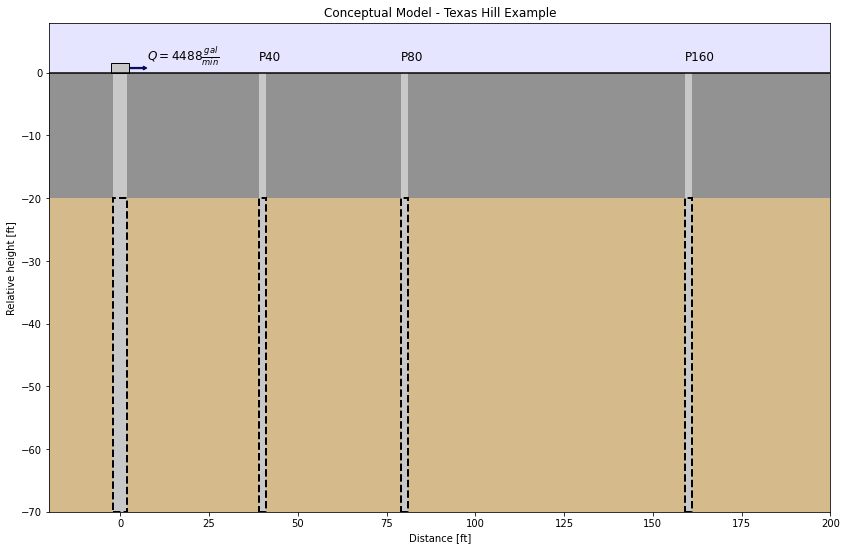

In [1]:
# Conceptual Model 1
import matplotlib.pyplot as plt
import numpy as np

##Now printing the conceptual model figure:

fig = plt.figure(figsize=(14, 9))
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-20, 0), width=220, height=8, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-20, -70),
    width=220,
    height=50,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
)
ax.add_patch(ground)

# Confining bed:
confining_unit = plt.Rectangle(
    (-20, -20),
    width=220,
    height=20,
    fc=np.array([100, 100, 100]) / 255,
    zorder=0,
    alpha=0.7,
)
ax.add_patch(confining_unit)

well = plt.Rectangle(
    (-2, -70), width=4, height=70, fc=np.array([200, 200, 200]) / 255, zorder=1
)
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle(
    (-2.5, 0), width=5, height=1.5, fc=np.array([200, 200, 200]) / 255, zorder=2, ec="k"
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-2, -70),
    width=4,
    height=50,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x=2.5, y=0.75, dx=5, dy=0, color="#00035b")
ax.add_patch(pumping_arrow)
ax.text(x=7.5, y=2, s=r"$ Q = 4488 \frac{gal}{min}$", fontsize="large")
# Piezometers
piez1 = plt.Rectangle(
    (39, -70), width=2, height=70, fc=np.array([200, 200, 200]) / 255, zorder=1
)
screen_piez_1 = plt.Rectangle(
    (39, -70),
    width=2,
    height=50,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_1.set_linewidth(2)

piez2 = plt.Rectangle(
    (79, -70), width=2, height=70, fc=np.array([200, 200, 200]) / 255, zorder=1
)
screen_piez_2 = plt.Rectangle(
    (79, -70),
    width=2,
    height=50,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_2.set_linewidth(2)

piez3 = plt.Rectangle(
    (159, -70), width=2, height=70, fc=np.array([200, 200, 200]) / 255, zorder=1
)
screen_piez_3 = plt.Rectangle(
    (159, -70),
    width=2,
    height=50,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_3.set_linewidth(2)


ax.add_patch(piez1)
ax.add_patch(screen_piez_1)
ax.add_patch(piez2)
ax.add_patch(screen_piez_2)
ax.add_patch(piez3)
ax.add_patch(screen_piez_3)

# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="k")
ax.add_line(line)

ax.text(x=39, y=2, s="P40", fontsize="large")
ax.text(x=79, y=2, s="P80", fontsize="large")
ax.text(x=159, y=2, s="P160", fontsize="large")


ax.set_xlim([-20, 200])
ax.set_ylim([-70, 8])
ax.set_xlabel("Distance [ft]")
ax.set_ylabel("Relative height [ft]")
ax.set_title("Conceptual Model - Texas Hill Example");

## Step 1. Load Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ttim import *

## Step 2. Set basic parameters

Here we have previously converted the exercise values to ***meters*** and ***days***.

In [3]:
Q = 24464.06  # constant discharge in m^3/d
b1 = 6.096  # overlying aquitard thickness in m
b2 = 15.24  # aquifer thickness in m
zt = -b1  # top boundary of aquifer
zb = -b1 - b2  # bottom boundary of aquifer
rw = 0.1524  # well radius in m

## Step 3. Load dataset of observation wells

Each observation well is located in a text file, where the first column is time data in days and the second column is drawdown in meters.
We also declare the distance of each observation to the wells: (```r1```:```r3```)

In [4]:
data1 = np.loadtxt("data/texas40.txt")
t1 = data1[:, 0]
h1 = data1[:, 1]
r1 = 12.191  # distance between obs1 to pumping well in m

data2 = np.loadtxt("data/texas80.txt")
t2 = data2[:, 0]
h2 = data2[:, 1]
r2 = 24.383  # distance between obs2 to pumping well in m

data3 = np.loadtxt("data/texas160.txt")
t3 = data3[:, 0]
h3 = data3[:, 1]
r3 = 48.766  # distance between obs3 to pumping well in m

## Step 4. Create a conceptual model

We define a Modelmaq model for the semi-confined aquifer using the methods described in previous notebooks (see below).
In this initial model, we will model the overlying layer as an aquitard with storage (```Sll```, the storage parameter, is defined in ModelMaq).

More details on model construction and theory can be seen in:

- [Confined 1 - Oude Korendijk](confined1_oude_korendijk)
- [Confined 4 - Schroth](confined4_schroth.ipynb)
- [Leaky 1 - Dalem](leaky1_dalem.ipynb)

In [5]:
ml_0 = ModelMaq(
    kaq=10,
    z=[0, zt, zb],
    Saq=0.001,
    Sll=0,
    c=10,
    tmin=0.001,
    tmax=1,
    topboundary="semi",
)
w_0 = Well(ml_0, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)], layers=0)
ml_0.solve()

self.neq  1
solution complete


## Step 5. Model Calibration

Using all three observation wells, we calibrate for the hydraulic parameters of the aquifer (```kaq``` and ```Saq```) and for the aquitard (```c``` and ```Sll```).

In [6]:
# unknown parameters: kaq, Saq, c, Sll
ca_0 = Calibrate(ml_0)
ca_0.set_parameter(name="kaq0", initial=10)
ca_0.set_parameter(name="Saq0", initial=1e-4)
ca_0.set_parameter_by_reference(
    name="Sll0", parameter=ml_0.aq.Sll, initial=1e-4, pmin=0
)
ca_0.set_parameter(name="c0", initial=100)
ca_0.series(name="OW1", x=r1, y=0, t=t1, h=h1, layer=0)
ca_0.series(name="OW2", x=r2, y=0, t=t2, h=h2, layer=0)
ca_0.series(name="OW3", x=r3, y=0, t=t3, h=h3, layer=0)
ca_0.fit(report=True)

.................................................................................................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 126
    # data points      = 78
    # variables        = 4
    chi-square         = 0.28305542
    reduced chi-square = 0.00382507
    Akaike info crit   = -430.268069
    Bayesian info crit = -420.841234
[[Variables]]
    kaq0:  224.589795 +/- 2.48600891 (1.11%) (init = 10)
    Saq0:  2.1313e-04 +/- 3.7534e-05 (17.61%) (init = 0.0001)
    Sll0:  1.7304e-06 +/- 2.7782e-04 (16055.52%) (init = 0.0001)
    c0:    43.8331237 +/- 3.15335028 (7.19%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(Saq0, Sll0) = -0.979
    C(kaq0, c0)   = 0.887
    C(Saq0, c0)   = -0.149
    C(kaq0, Saq0) = -0.118


In [7]:
display(ca_0.parameters)
print("RMSE:", ca_0.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,224.589795,2.486009,1.106911,-inf,inf,10,[224.5897947124587]
Saq0,0.000213,0.000038,17.610508,-inf,inf,0.0001,[0.0002131340798389554]
Sll0,0.000002,0.000278,16055.523283,0.0,inf,0.0001,[1.730365937868683e-06]
c0,43.833124,3.153350,7.193989,-inf,inf,100,[43.833123697435646]


RMSE: 0.06024048173207126


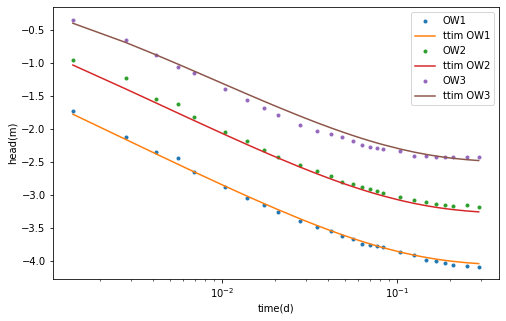

In [8]:
hm1_0 = ml_0.head(r1, 0, t1)
hm2_0 = ml_0.head(r2, 0, t2)
hm3_0 = ml_0.head(r3, 0, t3)
plt.figure(figsize=(8, 5))
plt.semilogx(t1, h1, ".", label="OW1")
plt.semilogx(t1, hm1_0[0], label="ttim OW1")
plt.semilogx(t2, h2, ".", label="OW2")
plt.semilogx(t2, hm2_0[0], label="ttim OW2")
plt.semilogx(t3, h3, ".", label="OW3")
plt.semilogx(t3, hm3_0[0], label="ttim OW3")
plt.xlabel("time(d)")
plt.ylabel("head(m)")
plt.legend();

Since the specific storage of the aquitard (```Sll```) is very close to the minimum limit (zero), we will test to set Sll to 0 and remove it from the calibration:

## Step 6. Model calibration without aquitard storage

In [9]:
ml_1 = ModelMaq(
    kaq=10,
    z=[0, zt, zb],
    Saq=0.001,
    Sll=0,
    c=10,
    tmin=0.001,
    tmax=1,
    topboundary="semi",
)
w_1 = Well(ml_1, xw=0, yw=0, rw=rw, tsandQ=[(0, Q)], layers=0)
ml_1.solve()

self.neq  1
solution complete


In [10]:
# unknown parameters: kaq, Saq, c
ca_1 = Calibrate(ml_1)
ca_1.set_parameter(name="kaq0", initial=10)
ca_1.set_parameter(name="Saq0", initial=1e-4)
ca_1.set_parameter(name="c0", initial=100)
ca_1.series(name="OW1", x=r1, y=0, t=t1, h=h1, layer=0)
ca_1.series(name="OW2", x=r2, y=0, t=t2, h=h2, layer=0)
ca_1.series(name="OW3", x=r3, y=0, t=t3, h=h3, layer=0)
ca_1.fit(report=True)

.....................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 50
    # data points      = 78
    # variables        = 3
    chi-square         = 0.28305317
    reduced chi-square = 0.00377404
    Akaike info crit   = -432.268689
    Bayesian info crit = -425.198562
[[Variables]]
    kaq0:  224.635193 +/- 2.46701615 (1.10%) (init = 10)
    Saq0:  2.1325e-04 +/- 7.5822e-06 (3.56%) (init = 0.0001)
    c0:    43.8841639 +/- 3.13605878 (7.15%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, c0)   = 0.890
    C(kaq0, Saq0) = -0.815
    C(Saq0, c0)   = -0.595


In [11]:
display(ca_1.parameters)
print("RMSE:", ca_1.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,224.635193,2.467016,1.098232,-inf,inf,10,[224.63519273946454]
Saq0,0.000213,0.000008,3.555577,-inf,inf,0.0001,[0.00021324780404289543]
c0,43.884164,3.136059,7.14622,-inf,inf,100,[43.884163861907204]


RMSE: 0.06024024248774193


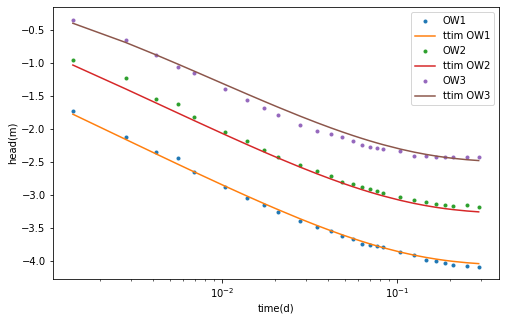

In [12]:
hm1_1 = ml_1.head(r1, 0, t1)
hm2_1 = ml_1.head(r2, 0, t2)
hm3_1 = ml_1.head(r3, 0, t3)
plt.figure(figsize=(8, 5))
plt.semilogx(t1, h1, ".", label="OW1")
plt.semilogx(t1, hm1_1[0], label="ttim OW1")
plt.semilogx(t2, h2, ".", label="OW2")
plt.semilogx(t2, hm2_1[0], label="ttim OW2")
plt.semilogx(t3, h3, ".", label="OW3")
plt.semilogx(t3, hm3_1[0], label="ttim OW3")
plt.xlabel("time(d)")
plt.ylabel("head(m)")
plt.legend();

The model with fixed Sll has a similar performance to the former model. The second model has an AIC value of -432.269, two units lower than the former model (-430.268). Thus, Sll should be set to zero (default value) and keep removed from the calibration.

## Step 7. Model Calibration with well parameters

We redo the model with the well parameters skin-resistance (```res```) and wellbore storage (```rc```)

In [13]:
ml_2 = ModelMaq(
    kaq=10,
    z=[0, zt, zb],
    Sll=0,
    Saq=0.001,
    c=10,
    tmin=0.001,
    tmax=1,
    topboundary="semi",
)
w_2 = Well(ml_2, xw=0, yw=0, rw=rw, res=0, rc=None, tsandQ=[(0, Q)], layers=0)
ml_2.solve()

self.neq  1
solution complete


Calibrate with the additional well paramenters

In [14]:
# unknown parameters: kaq, Saq, c, rc
ca_2 = Calibrate(ml_2)
ca_2.set_parameter(name="kaq0", initial=10)
ca_2.set_parameter(name="Saq0", initial=1e-4, pmin=0)
ca_2.set_parameter(name="c0", initial=10)
ca_2.set_parameter_by_reference(name="rc", parameter=w_2.rc, initial=0)
ca_2.set_parameter_by_reference(name="res", parameter=w_2.res, initial=0.1, pmin=0)
ca_2.series(name="OW1", x=r1, y=0, t=t1, h=h1, layer=0)
ca_2.series(name="OW2", x=r2, y=0, t=t2, h=h2, layer=0)
ca_2.series(name="OW3", x=r3, y=0, t=t3, h=h3, layer=0)
ca_2.fit(report=True)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [15]:
display(ca_2.parameters)
print("RMSE:", ca_2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,186.901532,1.027676e+01,5.498487,-inf,inf,10,[186.90153170230298]
Saq0,0.0,1.760474e-07,180814.644393,0.0,inf,0.0001,[9.736345063515728e-11]
c0,12.217242,2.435975e+00,19.938833,-inf,inf,10,[12.217242017113444]
rc,2.31173,9.075350e-02,3.925784,-inf,inf,0,[2.311729685846916]
res,0.0,5.806043e-07,280673.685285,0.0,inf,0.1,[2.0686097279565274e-10]


RMSE: 0.2826515392059663


When adding both res and rc in the calibration, the model fit is poor. The ```res``` value is being adjusted to very close to the minimum value 0. Thus, we repeat the calibration procedure, where res is removed from it.

In [16]:
# unknown parameters: kaq, Saq, c, rc
ca_2 = Calibrate(ml_2)
ca_2.set_parameter(name="kaq0", initial=10)
ca_2.set_parameter(name="Saq0", initial=1e-4)
ca_2.set_parameter(name="c0", initial=10)
ca_2.set_parameter_by_reference(name="rc", parameter=w_2.rc, initial=0)
ca_2.series(name="OW1", x=r1, y=0, t=t1, h=h1, layer=0)
ca_2.series(name="OW2", x=r2, y=0, t=t2, h=h2, layer=0)
ca_2.series(name="OW3", x=r3, y=0, t=t3, h=h3, layer=0)
ca_2.fit(report=True)

.........................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 78
    # variables        = 4
    chi-square         = 0.22837259
    reduced chi-square = 0.00308612
    Akaike info crit   = -447.011880
    Bayesian info crit = -437.585045
[[Variables]]
    kaq0:  227.476745 +/- 2.38403194 (1.05%) (init = 10)
    Saq0:  1.9189e-04 +/- 7.9503e-06 (4.14%) (init = 0.0001)
    c0:    45.1685665 +/- 2.92674386 (6.48%) (init = 10)
    rc:    0.58831953 +/- 0.06177017 (10.50%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0, c0)   = 0.885
    C(kaq0, Saq0) = -0.799
    C(Saq0, rc)   = -0.619
    C(Saq0, c0)   = -0.552
    C(kaq0, rc)   = 0.321
    C(c0, rc)     = 0.143


In [17]:
display(ca_2.parameters)
print("RMSE:", ca_2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0,227.476745,2.384032,1.048033,-inf,inf,10,[227.4767448937833]
Saq0,0.000192,0.000008,4.143071,-inf,inf,0.0001,[0.00019189384485118635]
c0,45.168566,2.926744,6.479603,-inf,inf,10,[45.16856645283155]
rc,0.58832,0.061770,10.499425,-inf,inf,0,[0.5883195294792068]


RMSE: 0.05410964530240864


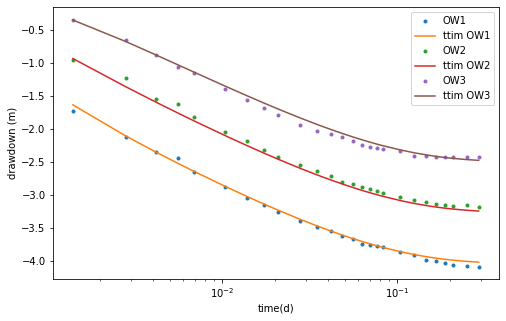

In [18]:
hm1_2 = ml_2.head(r1, 0, t1)
hm2_2 = ml_2.head(r2, 0, t2)
hm3_2 = ml_2.head(r3, 0, t3)
plt.figure(figsize=(8, 5))
plt.semilogx(t1, h1, ".", label="OW1")
plt.semilogx(t1, hm1_2[0], label="ttim OW1")
plt.semilogx(t2, h2, ".", label="OW2")
plt.semilogx(t2, hm2_2[0], label="ttim OW2")
plt.semilogx(t3, h3, ".", label="OW3")
plt.semilogx(t3, hm3_2[0], label="ttim OW3")
plt.xlabel("time(d)")
plt.ylabel("drawdown (m)")
plt.legend();

Now we have a much better fit. We also have better AIC and BIC values, which indicates that the extra parameter ```rc``` improved the model performance.

## Step 8. Analysis and summary of values

Here we compare the simulations done with TTim with the one done in AQTESOLV by Xinzhu (2020). TTim has found very similar values to AQTESOLV. When we consider the ```rc``` parameter in TTim, the fit is slightly better.

In [19]:
t = pd.DataFrame(
    columns=["k [m/d]", "Ss [1/m]", "c [d]", "rc"],
    index=["AQTESOLV", "ttim", "ttim-rc"],
)
t.loc["AQTESOLV"] = [224.726, 2.125e-4, 43.964, "-"]
t.loc["ttim"] = np.append(ca_1.parameters["optimal"].values, "-")
t.loc["ttim-rc"] = ca_2.parameters["optimal"].values
t["RMSE"] = [0.059627, ca_1.rmse(), ca_2.rmse()]
t

,k [m/d],Ss [1/m],c [d],rc,RMSE
AQTESOLV,224.726,0.000212,43.964,-,0.059627
ttim,224.635193,0.000213,43.884164,-,0.060240
ttim-rc,227.476745,0.000192,45.168566,0.58832,0.054110


## References

* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Newville, M.,Stensitzki, T., Allen, D.B., Ingargiola, A. (2014) LMFIT: Non Linear Least-Squares Minimization and Curve Fitting for Python.https://dx.doi.org/10.5281/zenodo.11813. https://lmfit.github.io/lmfit-py/intro.html (last access: August,2021).
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.